In [ ]:
# Dear user/implementor, please read carefully the comments. Thank you.
#Requirments:
# pandas, scipy, ski-kit, sklearn, fancyimuper
#(+ ecos, python 3.6, and keras needed),
#matplotlib, missingo
#XGboost model + it's requirments
# !pip install impyute
# !pip install -U scikit-fuzzy
# !pip install missingpy
# !pip install xgboost
# !pip install fancyimpute

import pandas as pd
from pandas import DataFrame as df
import numpy as np

from scipy.stats import pearsonr, shapiro, normaltest, kstest, uniform

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer, OneHotEncoder, MultiLabelBinarizer

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import xgboost as XGboost
import fancyimpute
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, SimpleFill, IterativeSVD
from missingpy import MissForest
import impyute as impy
import skfuzzy as fuzz

%matplotlib inline
import matplotlib.pyplot as plt
import missingno as msno
import random

#from ________ import NN_AutoEncoder

Using TensorFlow backend.


In [ ]:
# preview of the nulity of the data (the dispersion of missing data per feature)
import missingno as msno
%matplotlib inline

def show_missing_dispersion(df_vis):

    dfm= df_vis.loc[:, df_vis.isnull().any()]
    #matrix of the dispersion of data by columns
    msno.matrix(dfm)
    msno.bar(dfm, color="blue", log=True, figsize=(30,15))

    # heat map of data by correlation of nulity for features
    msno.heatmap(dfm, figsize=(20,20))

In [ ]:
#the input values that must be specified by user:

#the paths to the data file of feature: change the upload format!
full_input = pd.read_pickle("./df_retail2.pickle")

# The path to list of features you want to check: if all - leave it 'None'
load_list_of_features= None

full_input.shape

(139695, 3903)

In [ ]:
#finding the basic key and transaction features in columns
#cheching maximum nonunique, visualizing and removing dominanat NaNs features.
full_input.nunique().sort_values(ascending=False).head()

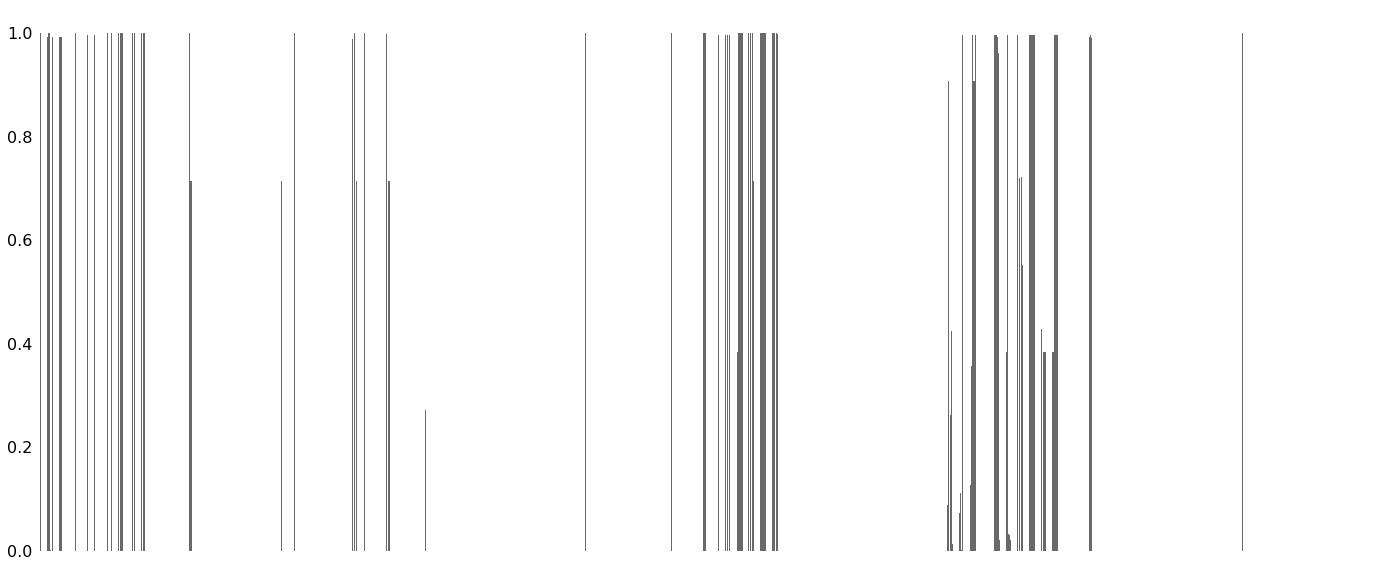

In [ ]:
msno.bar(full_input)

In [ ]:
full_input.isna().sum().sort_values(ascending=False)/len(full_input)

In [ ]:
# Dropping the columns with more than 50% NaNs
input_droped = full_input.dropna(axis=1, thresh=int(0.5*len(full_input)))
input_droped.shape

(139695, 585)

In [ ]:
sum(sum([input_droped.nunique()==1]))

262

In [ ]:
input_droped.loc[:,input_droped.nunique()!=1]
input_droped2=input_droped.drop(columns=input_droped.columns[input_droped.nunique()==1])
input_droped2.shape

(139695, 323)

In [ ]:
input_droped2.nunique().sort_values(ascending=False)

In [ ]:
key_cols = [col for col in input_droped2.columns if 'key' in col]
print(input_droped2[key_cols].nunique().sort_values(ascending=False))
#actimizetransactionkey
account_cols = [col for col in input_droped2.columns if 'account' in col]
print(input_droped2[account_cols].nunique().sort_values(ascending=False))
#actimizeaccountkey  actimizeenrichmentpayeeaccountkey
time_cols=input_droped2.filter(regex='time').columns
print(input_droped2[time_cols].nunique().sort_values(ascending=False))
#transactionnormalizeddatetime
balance_cols= input_droped2.filter(regex='balance').columns
print(input_droped2[balance_cols].nunique().sort_values(ascending=False))
#actimizecalculatedaccountcurrentbalance accountavailablebalance
amount_cols=input_droped2.filter(regex='amount').columns
print(input_droped2[amount_cols].nunique().sort_values(ascending=False))
#requestedamountnormalizedcurrency
fraud_cols=input_droped2.filter(regex='fraud').columns
print(input_droped2[fraud_cols].nunique().sort_values(ascending=False))
#fraud

In [ ]:
#provide the correct names of this features (columns):
name_frauds_labels=
name_account=
name_time_transaction=
name_amount_transaction =
name_balance=
name_key_transaction=
name_key_payee=
key_account_cols=[name_frauds_labels,name_account, name_time_transaction, name_amount_transaction, name_balance, name_key_transaction, name_key_payee  ]

In [ ]:
input_droped2[key_account_cols].nunique().sort_values(ascending=False)

In [ ]:
input_droped2.to_csv("./input_droped2.csv")
input_droped2[key_account_cols].count()

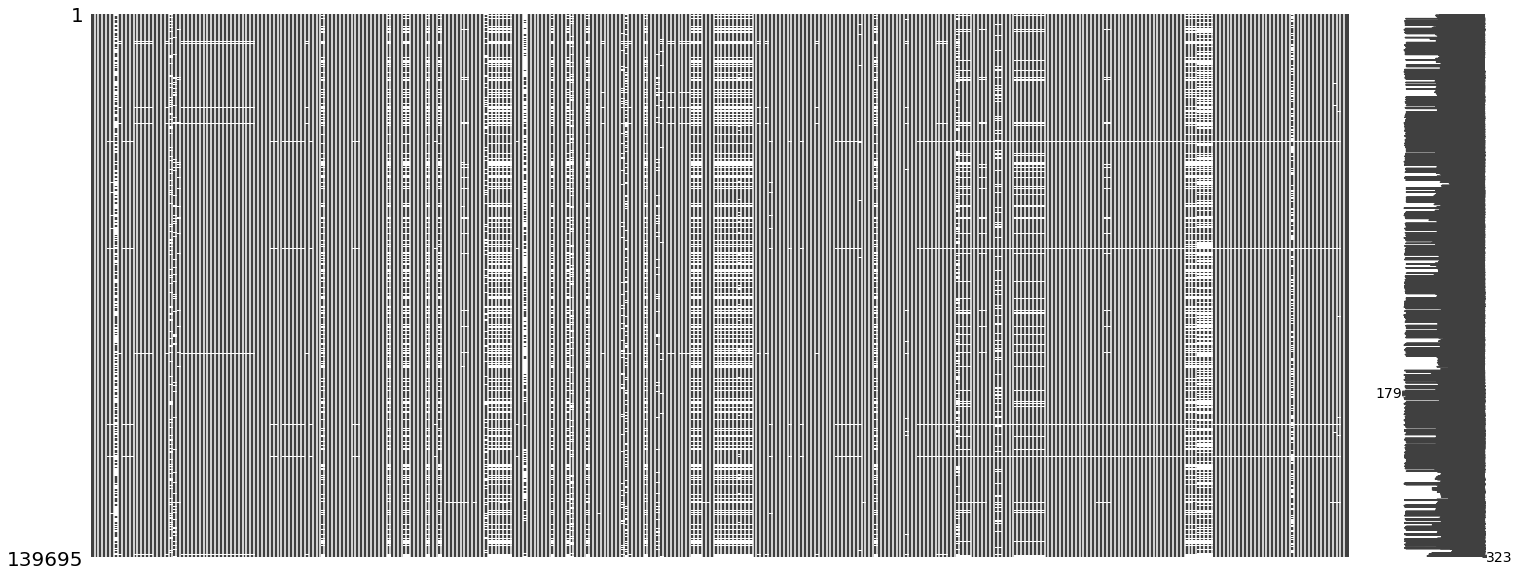

In [ ]:
msno.matrix(input_droped2)

In [ ]:
# the pathway of the functions:
# 1. show misssing dispersion
# 2. evaluate_feature:
        #calling: XGboost model and evaluate_*_features functions.
            #calling plot_matrix.
        #calling: prepare_colums function:
            #calling: impute_data function:
                            #calling imputation by types
                    #calling: plot_matrix.
        # calling : plot_confusin_matrix function.

df_features = input_droped2.drop(columns=name_frauds_labels)
y_labels = input_droped2[name_frauds_labels]

In [ ]:
evaluate_feature(input_droped2,load_list_of_features,y_labels)

In [ ]:
for x, y in input_droped2.iteritems():
    print(input_droped2[x].dtype, y.dtype)

Given unknown data set with differentr partial features, we would like to perform visual anlysis of the missing fractures of the data, in order to decide with later preproccessing of the missing values.

#Assuming invisability of the data we need to seperate our data by types
#The purpose is the later creqation of suitable categories for AI data alysis

In [ ]:
#input: missing data as df, labels as vector:
#output: modified columns - imputed by impute_data function, and the type of the feature category
#with transaction time, account and transaction key as indexes.

def prepare_columns(df_ini):

    types_of_features=pd.Series([])
    counts_nans = df_ini.isna()

    output_features= pd.DataFrame()
    binary_features= pd.DataFrame()
    categorical_features= pd.DataFrame()
    numeric_features= pd.DataFrame()
    time_sequental_features= pd.DataFrame()
    NLP_dedicted_features=pd.DataFrame()

    for name, column in df_ini.iteritems():
        how_many_Nunq= column.dropna().nunique().sum()

        if column.isna().sum() > 0:
            print('warning: the %s feature is missing by %s values, which are %2.d precents of input. Filled forward by account',
                      name, column.isna().sum(), column.isna().sum()/len(df_ini[0]) )

        if name == name_balance: #filling NaNs on the same account if possible
            column=df_ini.groupby([name_account])[name].fillna(method='ffill', inplace=True)
            types_of_features.append('numeric', index=name)
            output_features=pd.concat(column, axis=1, sort=False)
            numeric_features[name]=(pd.Series(float(column)))
            continue;

        elif name == (name_time_transaction | name_account | name_key_transaction | name_key_payee): #mandatory features for manipulations
            output_features.set_index(column, drop=False, append=True, inplace=True, verify_integrity=True)
            binary_features.set_index(column, drop=False, append=True, inplace=True, verify_integrity=True)
            categorical_features.set_index(column, drop=False, append=True, inplace=True, verify_integrity=True)
            numeric_features.set_index(column, drop=False, append=True, inplace=True, verify_integrity=True)
            NLP_dedicted_features.set_index(column, drop=False, append=True, inplace=True, verify_integrity=True)
            continue;

        elif how_many_Nunq ==1:
            df_ini.drop(columns=name, inplace=True), print('column %s dropped due to single value',name)
            continue;

        elif how_many_Nunq ==2: #convert to 1 and 0
            what_nonunis=column.nunique()
            if (what_nonunis[0] < what_nonunis[1]):
                column[[what_nonunis[0]]].set_value(0, inplace=True)
                column[[what_nonunis[1]]].set_value(1, inplace=True)
            else:
                column[[what_nonunis[0]]].set_value(1, inplace=True)
                column[[what_nonunis[1]]].set_value(0, inplace=True)

            binary_features[name]=pd.Series(int(column))               #ad to binary features
            types_of_features.append('binary', index=name)
            continue;

        elif (column.dtype == np.bool):
            types_of_features.append('binary', index=name)
            column[[True]].set_value(1, inplace=True)
            column[[False]].set_value(0, inplace=True)
            binary_features[name]=pd.Series(int(column))   #ad to binary features
            continue;

        elif (column.dtype == np.float64 or column.dtype == np.int64 or column.dtype == int32 or column.dtype == int64):
            print(name, column.dtype)
            if (how_many_Nunq <= 1000):
                categorical_features[name]=(pd.cut(column, bins=1000)) #ad to categorical features
                types_of_features.append('categorical', index=name)
            else:
                numeric_features[name]=pd.Series(float(column))
                types_of_features.append('numeric', index=name)
            continue;
            #add to numeric features (needed back conversion in explanations)

        elif (column.dtype == ('str' | 'unicode' | 'object')):

            if (how_many_Nunq <= 1000):
                categorical_features[name]=(pd.cut(column, bins=1000))
                types_of_features.append('categorical', index=name)
                                       #ad to categorical features by binning the feature to 1000 bins
            else:
                NLP_dedicted_features[name]==pd.Series(str(column))
                types_of_features.append('str', index=name) # to langueage proccessing
            continue;

        elif dtype(column)=='datetime':
            #order and ffil by...? by K-means? by other features?
            time_sequental_features.append('datetime', index=name)
            time_sequental_features[name]=(pd.Series(column)) # to time proccessing
            continue;

        else: print('%s udefined data type', column);

#the features recollected by the types of the data for further editing
    output_features=pd.concat([output_features, impute_data(binary_features, type_f='binary')], axis=1, sort=False)
    output_features=pd.concat([output_features, impute_data(numeric, type_f='numeric')], axis=1, sort=False)
    output_features=pd.concat([output_features, impute_data(categorical, type_f='categorical')], axis=1, sort=False)
    output_features=pd.concat([output_features, impute_data(NLP_dedicted_features, type_f='NLP')], axis=1, sort=False)

    df_for_stats=df_ini[name_time_transaction,name_amount_transaction, name_balance]
    numeric_stats = calculate_time_stats(df_for_stats)
    numeric_features=pd.concat([numeric_features, numeric_stats], axis=1, sort=False)
    output_features=pd.concat([output_features, numeric_stats], axis=1, sort=False)

    return(output_features)


In [ ]:
#Evaluation of missing data by creating data sets without the estimated feature
#comparing performaces of the model:
#with the feature
#without the feature (mis)
#and with the feature totally imputated by the distribution type (imp)

#the input:
#must be only features! Without NaNs, after imputation!
#the output:
# For each feature in the list:
#a confusion matrix with true results vs random vs missing (ONE and all).

def evaluate_features(df_X, df_y, list_columns=None):

    if list_of_columns==None: list_of_columns=df_X.columns() #if no selection made, test all columns
    results_missing=[]
    results_missing_all=[]
    results_smart_impute=[]
    results_dumb_impute=[]
    results_smart_imp_one=[]

    train_X, train_y, test_X, tesy_y = train_test_split(df_X, df_y, test_size=0.3, random_state=42)

    XGboost_misal=XGboost.fit(train_X.drop(columns=list_columns, inplace=False), train_y)
    results_missing_all= XGboost_misal.predict(test_X.drop(columns=list_columns, inplace=False))

    corr_misal, p_misal = pearsonr(df_y, results_missing_all)
    print('The pearson correlation of results with missing all features: %s %.3f correlation and %.3f p-value' %(name, corr_misal, p_misal))
    print('the confusion matrics and the precision for missing features:')
    plot_confusion_matrix(df_y, results_missing_all)
    #the output should one be for for all missing features

#For dumb imputation: we check only the given (if any, else all) columns
#and creating statistical estimates according to distribution type:
    for name, column in df_X.iteritems(list_columns):

        XGboost_mis=XGboost.fit(train_X.drop(columns=name, inplace=False), train_y)
        results_missing= XGboost_mis.predict(test_X.drop(columns=name, inplace=False))

        corr_mis, p_mis = pearsonr(df_y, results_missing)
        print('The pearson correlation of results without ONE missing feature: %s %.3f correlation and %.3f p-value' %(name, corr_mis, p_mis))
        print('the confusion matrics and the precision for %s missing:', name)
        plot_confusion_matrix(df_y, results_missing)
        #the output should be for each missing feature... N in total

        if column.nunique().sum() == 2:  column_dum = evaluate_binary_feature(column)
        elif column.nunique().sum() <= 1000:  column_dum = evaluate_categorical_feature(column)

        elif dtype(column)==('float' | 'int'): column_dum = evaluate_numeric_feature(column) #  The data is numeric.
        elif dtype(column)=='bool':  column_dum = evaluate_binary_feature(column) # this is the binary category
        elif dtype(column)=='datetime': continue;
        else: column_dum = evaluate_str_feature(column) #assuming all other features are textual

        modified_X = train_X.drop(columns=name).assign(column_dum)

        XGboost_imp_dum = XGboost.fit(modified_X, train_y)
        results_dumb_impute = XGboost_imp_dum.predict(test_Xdrop(columns=name).assign(column_dum))

        corr_idumb, p_dumb = pearsonr(df_y, results_dumb_impute)
        print('The pearson correlation of results with ONE dummy imputed feature: %s %.3f correlation and %.3f p-value' %(name, corr_dumb, p_dumb))
        print('the confusion matrics and the precision for %s dummy imputed feature:', name)
        plot_confusion_matrix(df_y, results_dumb_impute)
        #the output should be for each imputed feature...

    df_smart_part_imputed = prepare_columns(df_X)
    miss_overal_imputer= MissForest(decreasing=True, copy=False)
    df_smart_imputed = miss_overal_imputer(df_smart_part_imputed)
    train_Xm, train_ym, test_Xm, tesy_ym = train_test_split(df_smart_imputed, df_y, test_size=0.3, random_state=42)

    for name, column in df_X.iteritems(list_columns):

        XGboost_imp_smart = XGboost.fit(train_Xm, train_ym)
        results_smart_impute = XGboost_imp_smart.predict(test_Xm)

        XGboost_imp_one = XGboost.fit(train_Xm.drop(list_columns).assign(name), train_ym)
        results_smart_imp_one = XGboost_imp_one.predict(test_Xm.drop(list_columns).assign(name))

        corr_imp_one, p_imp_one = pearsonr(df_y, results_dumb_impute)
        print('The pearson correlation of results with ONE smart imputed feature: %s %.3f correlation and %.3f p-value' %(name, corr_imp_one, p_imp_one))
        print('the confusion matrics and the precision for ONE smarrt imputed feature:')
        plot_confusion_matrix(results, results_dumb_impute)
        #the output should be for each imputed feature..

#mind the gap!
#the following are overall results and don't need to be in a loop
    corr_smart, p_smart = pearsonr(df_y, results_smart_impute)
    print('The pearson correlation of results with all smart imputed feature: %s %.3f correlation and %.3f p-value' %(name, corr_smart, p_smart))
    print('the confusion matrics and the precision for all smart imputed feature:')
    plot_confusion_matrix(results, results_smart_impute)



In [ ]:
#This function prints and plots the confusion matrix. Requeried for further run
#Normalization can be applied by setting `normalize=True`

#input: true labels, predicted labes
#outputs: pretty confusion matrixes

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [ ]:
#define the data type distribution
#If Data Is Gaussian: Use Parametric Statistical Methods
#else Use Nonparametric Statistical Methods
#Testing for normality with two tests

def evaluate_numeric_feature(column):
    feature_mean = column.mean()
    feature_std = column.std()
    alpha = 0.025
    stat, p = shapiro(column)
    print('Shapiro test for normality=%.3f, p=%.3f' % (stat, p))

    if p > alpha:
        print(name, 'feature %s looks Gaussian: H0 accepted by Shapiro test for 0.1 p-value')
        print('The feature would be reconstructed as normal, with %.3f mean and %.3f std' %(feature_mean, feature_std))
        new_column = pd.Series( [np.random.normal(feature_mean, feature_std, len(column))], name=name)

    else:
        print('Sample does not look Gaussian by Shapiro with p-value 0.1 (reject H0)')
        stat, p = normaltest(column)
        print('D’Agostino Normality test =%.3f, p=%.3f' % (stat, p))

        if p > alpha:
            print(name, 'feature %s looks Gaussian: H0 accepted by D’Agostino Normality test for 0.1 p-value')
            print('The feature would be reconstructed as normal, with %.3f mean and %.3f std' %(feature_mean, feature_std))
            new_column = pd.Series( [np.random.normal(feature_mean, feature_std, len(column))], name=name)
#linearity test for feature D’Agostino test for continious distribution
        else:
            print('Sample does not look Gaussian by D’Agostino Normality test with p-value 0.1 (reject H0)')
            k_corr, p_ks = kstest(column, uniform(loc=column.min(), scale=column.max()).cdf)
            print('Correlation value with linear distribution is %.3f score with p-value of %/3f' % (k_corr, p_ks))

            if p_ks > alpha:
                print(name, 'Feature %s looks lineary distributed by %.3f Kolmagorov- Smirnov test, with p-value %/3f:' % (k_corr, p_ks))
                print('The feature would be reconstructed as linear, with range of minimum %.3f  and maximum %.3f ' %(column.min(), column.max()))
                new_column = pd.Series( [np.random.unifor(column.min(), column.max(), len(column))], name=name)
#assuming random or unknown distribution
            else:
                new_column = pd.Series([np.rand(column.min(), column.max(), len(column))], name=name)

    return(new_column)


# the input: column to be dummy imputed
# must be only categorical  features that limited to ~1000-10000,
# and much smaller than the data set!! n << M
# Without NaNs, after imputation!
# the output:
# For each feature: imputed feature by statistical occurence of the category

def evaluate_categorical_feature(column):

    feature_counts[column.unique()] = column.nunique().count()
    print(name, '/n', feature_counts[1:3])

    feature_std = feature_counts.std()
    feature_range= feature_counts.max()- feature_counts.min()

    if feature_std / feature_range  <= 0.337:    #densed ~ normal
        new_column = pd.Series( [np.random.normal(feature_counts.mean(), feature_std, len(column))], name=name)
           # back_to_feature=feature_counts.key[feature_counts.value==closest[new_colum]] ## how???

    elif (feature_std / feature_range > 0.337 & feature_std /feature_range < 0.773):
        new_column= scipy.stats.rv_discrete(values=(column.nunique(), column.nunique().count()/column.nunique().count().sum()))
        #sample from distribution according to percentage, it's not a symmetrical dispersion

    else:
        new_column = pd.Series([np.rand(column.min, column.max, len(column))], name=name)
        #feature_std / feature_range  >= 0.773
        # back_to_feature=feature_counts.key[feature_counts.value==closest[new_colum]] ## how???
    return(new_column);

def evaluate_str_feature(column):
    new_column= scipy.stats.rv_discrete(values=(column.nunique(), column.nunique().count()/column.nunique().count().sum()))
    #random.choices(column, k=len(column))



In [ ]:
def calculate_time_stats(df_for_time_stats):
    df_for_time_stats['week_year'] = df_for_time_stats['name_time_transaction'].dt.strftime('%U-%Y')
    df_for_time_stats['month_year'] = df_for_time_stats['name_time_transaction'].dt.strftime("%m-%Y")

    df = df.groupby('month_year').agg({
        'name_amount_transaction': {
            'amount_mean_M': pd.Series.mean,
            'amount_max_M': pd.Series.max,
            'amount_min_M': pd.Series.min,
            'amount_count_M': np.alen,
            'amount_delta_M': test_diff
        },
        'name_balance': {
            'balance_mean_M': pd.Series.mean,
            'balance_max_M': pd.Series.max,
            'balance_min_M': pd.Series.min,
            'balance_sum_M': pd.Series.sum,
        }

    })

    df.columns = df.columns.droplevel()

    #if df.amount_mean_M.count() < 20: return None

    df.balance_mean_M.fillna(method='ffill', inplace=True)
    df.balance_max_M.fillna(df.balance_mean_M, inplace=True)
    df.balance_min_M.fillna(df.balance_mean_M, inplace=True)
    df.fillna(0, inplace=True)


    df=df.groupby('week_year').agg({
        'name_amount_transaction': {
            'amount_mean': pd.Series.mean,
            'amount_max': pd.Series.max,
            'amount_min': pd.Series.min,
            'amount_count': np.alen,
            'amount_delta': test_diff
        },
        'name_balance': {
            'balance_mean': pd.Series.mean,
            'balance_max': pd.Series.max,
            'balance_min': pd.Series.min,
            'balance_sum': pd.Series.sum,
            'balance_delta': test_diff
        }
    })

    df.columns = df.columns.droplevel()

    #if df.amount_mean.count() < 10: df.balance_mean.fillna(df.balance_mean_M, inplace=True)
    df.balance_mean.fillna(method='ffill', inplace=True)
    df.balance_max.fillna(df.balance_mean, inplace=True)
    df.balance_min.fillna(df.balance_mean, inplace=True)
    df.fillna(0, inplace=True)

    return df


In [ ]:
#https://pypi.org/project/fancyimpute/
# pip install impyute
# pip install -U scikit-fuzzy
# pip install missingpy
# import impyute as impy - another option
# we go by accounts only, because we are trying to model the
# single user behavious and not multi -users dependencies (for now).

import fancyimpute
import scikit_fuzzy
import skfuzzy as fuzz
from missingpy import MissForest
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, SimpleFill, IterativeSVD
from sklearn.preprocessing import Imputer, OneHotEncoder, MultiLabelBinarizer

def impute_data(df_x_type, type_f):
# if we have variance: the EM or regressions, or multiply imputation
    x_filled=pd.DataFrame()

    if type_f == 'numeric':
        print('numeric yes')
        df_grouped = df_x_type.groupby(name_account)
        for key, df_group in df_grouped:
            if df_group.count() >30:
                for name, column in df_group.iteritems():
                    alpha = 0.025
                    stat, p = shapiro(column)
                    if p > alpha:
                        df_group[name] = SimpleFill('mean').fit_transform(column)
                    else:
                        k_corr, p_ks = kstest(column, uniform(loc=column.min(), scale=column.max()).cdf)
                        if p_ks > alpha:
                            df_group[name] = df_group.apply(lambda x: np.random.choice(df_group[name].dropna().values) if np.isnan(x) else x)

                df_group = KNN(k=5).fit_transform(df_group)
                X_filled[key]=df_group
                #combine modified account information to results

                # when we cant use parametrical statistic
                # wew go to predictive matrixes models - (when we have less than 30 entries per account).
            else: X_filled[key]=df_group #leave empty for further imputation by all accounts

        X_filled = IterativeSVD().fit_transform(X_filled)
        ##slow for large matrices, maybe be should be taken inside for loop- per account

        df_x_type.columns = df_x_type.columns.droplevel()
        return(x_filled)

    elif type_f == 'binary':
# The graph method can estimate values based on unrelatedness of the events
#(for more complicated combinatorics some rules between features and hidden estimates are assigned)
        MFimputer = MissForest(decreasing=True, copy=False)
        df_grouped = df_x_type.groupby(name_account)
        for key, df_group in df_grouped:
            if df_group.count() > 30:
                df_group = MFimputer.fit_transform(df_group)
                X_filled[key]=df_group
            else: X_filled[key]=df_group #leave empty for further imputation by all accounts
        X_filled =  imputer.fit_transform(X_filled)
        bin_mse = ((X_filled[key] - df_group[key]) ** 2).mean()
        print("MissForest imputer MSE: %f" % bin_mse)
        print('binary yes')
        df_x_type.columns = df_x_type.columns.droplevel()
        return(x_filled)

    elif type_f == 'categorical':
        enc = OneHotEncoder(handle_unknown='ignore')
        df_grouped = df_x_type.groupby(name_account)
        for key, df_group in df_grouped:
            if df_group.shape[0]>30:
                encoded_group = enc.fit_transform(df_group)
                encoded_gr_filled = NuclearNormMinimization().fit_transform(encoded_group)
                X_gr_filled= enc.inverse_transform(encoded_gr_filled)
                X_filled[key]= X_gr_filled
            else: X_filled[key]=df_group

        #fill the minority by all accounts data
        encoded_x = enc.fit_transform(X_filled)
        encoded_filled = NuclearNormMinimization().fit_transform(encoded_x)
        X_filled= enc.inverse_transform(encoded_filled)
        categ_mse = ((X_filled[key] - df_group[key]) ** 2).mean()
        print("NuclearNormMinimization MSE: %f" % categ_mse)
        print('categorical yes')
        df_x_type.columns = df_x_type.columns.droplevel()

        return(x_filled)


    elif type_f == 'NLP':

        df_grouped = df_x_type.groupby(name_account)
        for key, df_group in df_grouped:
            if df_group.count() > 30:
                encoded_group = NN_AutoEncoder.fit_transform(df_group)
                X_filled[key]= X_gr_filled

            else: X_filled[key]=df_group #leave empty for further imputation by all accounts

        #fill the minority by all accounts data
        # using NNs Autoencoder architecture do encode unknown values by neuro fuzzy the known data to hidden features
        X_filled= NN_AutoEncoder.fit_transform(X_filled)
        # NN_AutoEncoder we can use prepaired function, of construct de novo
        df_x_type.columns = df_x_type.columns.droplevel()
        nlp_mse = ((X_filled[key] - df_group[key]) ** 2).mean()
        print("NuclearNormMinimization MSE: %f" % nlp_mse)
        print('nlp yes')
        return(x_filled)


    else : print('%s udefined data', type_f)
    return('Nope')



In [ ]:
## http://mlg.eng.cam.ac.uk/zoubin/papers/nips93.pdf
# EM imputation
# https://arxiv.org/pdf/1801.03583.pdf
# Graphic imputation
# https://arxiv.org/ftp/arxiv/papers/0812/0812.2412.pdf
# random forest imputation
# https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87
# techniques
# https://www.statsmodels.org/devel/imputation.html
# multipliply imputation with chained equations